## TITLE: Train LSTM
### AUTHOR: Harrison
### DATE: 2025-04-23
##### DESCRIPTION: Trains LSTM on CAMELS data for discharge prediction


In [1]:
import os
import logging
import sys

# Project directory structure
PROJECT_DIR = os.path.dirname(os.path.abspath(''))
DATA_DIR = os.path.join(PROJECT_DIR, 'data')
USGS_DATA_DIR = os.path.join(DATA_DIR, 'raw', 'usgs_streamflow')
FORCING_DATA_DIR = os.path.join(DATA_DIR, 'raw', 'basin_mean_forcing', 'nldas')
STATIC_DATA_DIR = os.path.join(DATA_DIR, 'raw', 'basin_metadata')
FIGURE_DIR = os.path.join(PROJECT_DIR, 'outputs', 'figures')
os.chdir(PROJECT_DIR)

In [ ]:
import pandas as pd
# Create dictionary for storing data
data_dict = {}

# Define column names
columns = ['STAID', 'YEAR', 'MONTH', 'DAY', 'Q', 'QAQC']
# Read in all data
for huc in os.listdir(USGS_DATA_DIR):
    for basin_data in os.listdir(os.path.join(USGS_DATA_DIR, huc)):
        # Read in fixed width .txt file as a dataframe
        basin_df = pd.read_fwf(os.path.join(USGS_DATA_DIR, huc, basin_data), 
                               header=None, names=columns,
                               dtype={'STAID': str, 'QAQC': str})
        # Convert date columns to datetime and set as index
        basin_df['DATE'] = pd.to_datetime(basin_df[['YEAR', 'MONTH', 'DAY']])
        basin_df.set_index('DATE', inplace=True)
        # Drop unnecessary columns
        basin_df.drop(columns=['YEAR', 'MONTH', 'DAY', 'QAQC'], inplace=True)
        # Add dataframe to dictionary
        data_dict[basin_df['STAID'].iloc[0]] = basin_df

In [ ]:
import matplotlib.pyplot as plt

# Read in forcing data
for huc in os.listdir(FORCING_DATA_DIR):
    for basin_data in os.listdir(os.path.join(FORCING_DATA_DIR, huc)):
        # Get basin number
        basin_no = basin_data.split('_')[0]
        # Read in dataframe 
        basin_df = pd.read_csv(os.path.join(FORCING_DATA_DIR, huc, basin_data), skiprows=3, sep=r'\s+')
        basin_df.rename(columns={'Mnth': 'Month'}, inplace=True)
        # Convert date columns to datetime and set as index
        basin_df['DATE'] = pd.to_datetime(basin_df[['Year', 'Month', 'Day']])
        basin_df.set_index('DATE', inplace=True)
        # Drop unnecessary columns
        basin_df.drop(columns=['Year', 'Month', 'Day', 'Hr'], inplace=True)
        
        # Make sure all dtypes are numeric
        for dtype in basin_df.dtypes:
            assert dtype != object
            
        # Concatenate forcing dataframe with discharge dataframe
        try:
            data_dict[basin_no] = pd.concat([data_dict[basin_no], basin_df], axis=1)
        except Exception as e:
            print(f"STAID not found: {e}")

STAID not found: '01150900'


: 

In [ ]:
# Read in annual average hydrometeorological data
HMET_STATIC_COLS = ['HUC', 'STAID', 'Annual Runoff (mm d-1)', 'Annual Precip (mm d-1)', 'Annual PET (mm d-1)', 'Annual Temp (C)']
STATIC_COLS = ['HUC', 'STAID', 'DA (km2)', 'Elevation (m)', 'Slope (m km-1)', 'Frac Forest (%)']
hmet_static_df = pd.read_csv(os.path.join(STATIC_DATA_DIR, 'basin_annual_hydrometeorology_characteristics_nldas.txt'), 
                             sep=r'\s+', names=HMET_STATIC_COLS, dtype={'STAID': str}, header=0)

static_df = pd.read_csv(os.path.join(STATIC_DATA_DIR, 'basin_physical_characteristics.txt'), sep=r'\s+',
                        names=STATIC_COLS, dtype={'STAID': str}, header=0)

# Append static data to respective basin dataframe
for basin, df in data_dict.items():
    row_hmet = hmet_static_df[hmet_static_df['STAID'] == basin]
    row = static_df[static_df['STAID'] == basin]
    row_hmet.name = basin
    if not row_hmet.empty:
        static_values_hmet = row_hmet.iloc[0]
        static_values = row.iloc[0]
        
    # Append HMET static variables
    data_dict[basin]['Annual Runoff (mm d-1)'] = static_values_hmet['Annual Runoff (mm d-1)']
    data_dict[basin]['Annual Precip (mm d-1)'] = static_values_hmet['Annual Precip (mm d-1)']
    data_dict[basin]['Annual PET (mm d-1)'] = static_values_hmet['Annual PET (mm d-1)']
    data_dict[basin]['Annual Temp (C)'] = static_values_hmet['Annual Temp (C)']
    
    # Append static variables
    data_dict[basin]['DA (km2)'] = static_values['DA (km2)']
    data_dict[basin]['Elevation (m)'] = static_values['Elevation (m)']
    data_dict[basin]['Slope (m km-1)'] = static_values['Slope (m km-1)']
    data_dict[basin]['Frac Forest (%)'] = static_values['Frac Forest (%)']

: 

In [7]:
# Turn data dict into master dataframe
master_df = pd.concat(data_dict.values(), axis=0)
master_df.dropna(inplace=True)
print(master_df.index.dtype)
master_df.tail(100)


datetime64[ns]


,STAID,Q,Dayl(s),PRCP(mm/day),SRAD(W/m2),SWE(mm),Tmax(C),Tmin(C),Vp(Pa),Annual Runoff (mm d-1),Annual Precip (mm d-1),Annual PET (mm d-1),Annual Temp (C),DA (km2),Elevation (m),Slope (m km-1),Frac Forest (%)
DATE,,,,,,,,,,,,,,,,,
2014-09-23,11532500,248.0,42854.40,0.08,384.24,0.0,13.88,13.88,1162.45,5.609,7.227,2.717,8.859,1590.16,725.07,112.11076,0.9993
2014-09-24,11532500,567.0,42508.80,57.35,204.80,0.0,12.55,12.55,1235.29,5.609,7.227,2.717,8.859,1590.16,725.07,112.11076,0.9993
2014-09-25,11532500,740.0,42508.80,5.09,372.72,0.0,11.14,11.14,1105.29,5.609,7.227,2.717,8.859,1590.16,725.07,112.11076,0.9993
2014-09-26,11532500,412.0,42163.20,1.41,378.95,0.0,11.65,11.65,1121.68,5.609,7.227,2.717,8.859,1590.16,725.07,112.11076,0.9993
2014-09-27,11532500,342.0,42163.20,0.00,459.81,0.0,12.05,12.05,1092.11,5.609,7.227,2.717,8.859,1590.16,725.07,112.11076,0.9993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-27,11532500,-999.0,32313.36,0.00,252.75,0.0,5.26,5.26,583.13,5.609,7.227,2.717,8.859,1590.16,725.07,112.11076,0.9993
2014-12-28,11532500,-999.0,32359.96,0.51,247.28,0.0,5.70,5.70,720.31,5.609,7.227,2.717,8.859,1590.16,725.07,112.11076,0.9993
2014-12-29,11532500,-999.0,32405.01,2.08,217.23,0.0,4.25,4.25,636.83,5.609,7.227,2.717,8.859,1590.16,725.07,112.11076,0.9993


In [8]:
master_df.to_csv(os.path.join(DATA_DIR, 'processed', 'master_df.csv'), index=True)

In [28]:
# Scale data from 0 - 1
from sklearn.preprocessing import MinMaxScaler
cols_to_scale = list(master_df.columns)
STAID = master_df['STAID']
cols_to_scale.remove('STAID')
print(cols_to_scale)

scaler = MinMaxScaler()
master_df_sc = pd.DataFrame(scaler.fit_transform(master_df[cols_to_scale]), columns=cols_to_scale, index=master_df.index)
# Reappend STAID
master_df_sc['STAID'] = STAID

y_scaler = MinMaxScaler()
y_scaler.fit(master_df['Q'].values.reshape(-1, 1))

['Q', 'Dayl(s)', 'PRCP(mm/day)', 'SRAD(W/m2)', 'SWE(mm)', 'Tmax(C)', 'Tmin(C)', 'Vp(Pa)', 'Annual Runoff (mm d-1)', 'Annual Precip (mm d-1)', 'Annual PET (mm d-1)', 'Annual Temp (C)', 'DA (km2)', 'Elevation (m)', 'Slope (m km-1)', 'Frac Forest (%)']


MinMaxScaler()

In [29]:
master_df_sc.head()

,Q,Dayl(s),PRCP(mm/day),SRAD(W/m2),SWE(mm),Tmax(C),Tmin(C),Vp(Pa),Annual Runoff (mm d-1),Annual Precip (mm d-1),Annual PET (mm d-1),Annual Temp (C),DA (km2),Elevation (m),Slope (m km-1),Frac Forest (%),STAID
DATE,,,,,,,,,,,,,,,,,
1980-01-01,0.013339,0.040882,0.0,0.276722,0.0,0.525191,0.525191,0.051708,0.169854,0.221264,0.33727,0.709084,0.089094,0.067425,0.081687,0.9063,01013500
1980-01-02,0.013218,0.043722,0.0,0.247028,0.0,0.544626,0.544626,0.061227,0.169854,0.221264,0.33727,0.709084,0.089094,0.067425,0.081687,0.9063,01013500
1980-01-03,0.013097,0.046933,0.0,0.244893,0.0,0.520033,0.520033,0.042245,0.169854,0.221264,0.33727,0.709084,0.089094,0.067425,0.081687,0.9063,01013500
1980-01-04,0.013057,0.049195,0.0,0.270589,0.0,0.493046,0.493046,0.032522,0.169854,0.221264,0.33727,0.709084,0.089094,0.067425,0.081687,0.9063,01013500
1980-01-05,0.012936,0.049376,0.0,0.257582,0.0,0.483191,0.483191,0.031050,0.169854,0.221264,0.33727,0.709084,0.089094,0.067425,0.081687,0.9063,01013500


In [34]:
import numpy as np
import random

def train_test_split_evenSites(df, split_pct, seed):
    # Set random seed
    np.random.seed(seed)
    random.seed(seed)
    
    # Get unique site identifiers
    sites = df['STAID'].unique()
    
    # Store splits here
    train_splits = []
    test_splits  = []
    
    for site in sites:
        temp_df = df[df['STAID'] == site]
        split_ind = int(np.floor((1-split_pct)*int(len(temp_df))))
        start_ind = np.random.randint(0, len(temp_df) - split_ind)
        end_ind = start_ind + split_ind
        test_df = temp_df.iloc[start_ind:end_ind, :]
        train_df = pd.concat([temp_df.iloc[:start_ind, :], temp_df.iloc[end_ind:, :]])
        train_splits.append(train_df)
        test_splits.append(test_df)

    # Zip lists together, shuffle them, then unzip them
    zipped_list = list(zip(train_splits, test_splits))
    random.shuffle(zipped_list)
    train_splits, test_splits = zip(*zipped_list)
    
    Train = pd.concat(train_splits)
    Test = pd.concat(test_splits)
    
    Train.drop("STAID", axis=1, inplace=True)
    Test.drop('STAID', axis=1, inplace=True)
    
    X_train = Train.drop('Q', axis=1)
    y_train = Train['Q']
    X_test = Test.drop('Q', axis=1)
    y_test = Test['Q']
    
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = train_test_split_evenSites(master_df_sc, 0.8, 42)

In [36]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(6751320, 15) (6751320,) (1687180, 15) (1687180,)


In [38]:
def data_generator(X, y, window_length, batch_size):
    X_array = X.to_numpy(dtype=np.float32)
    y_array = y.to_numpy(dtype=np.float32)
    n_samples = len(X)

    while True:
        indices = np.arange(n_samples - window_length + 1)
        X_batch = []
        y_batch = []
        
        # for site, indices in valid_sequences.items():
        for i in indices:
            # Get start and end dates of sequence
            sequence_start = X.index[i]
            sequence_end = X.index[i + window_length - 1]
            if (sequence_end - sequence_start).days == window_length - 1:
                X_seq = X_array[i:i + window_length]
                y_seq = y_array[i + window_length - 1]
                
                X_batch.append(X_seq)
                y_batch.append(y_seq)
                
                if len(X_batch) == batch_size:
                    y_batch_array = np.array(y_batch)
                    yield np.array(X_batch), np.array(y_batch)
                    X_batch, y_batch = [], []
            
        if X_batch and y_batch:  # If there are any remaining sequences not yielded yet
            yield np.array(X_batch), np.array(y_batch)

def get_steps_per_epoch(X, window_length, batch_size):
    """A function to count the number of valid sequences in the training data, X

    Args:
        X (pd.DataFrame or np.array): The training data
        window_length (int): The window length for input to the LSTM
        batch_size (int): The batch size for the LSTM

    Returns:
        int: the number of steps per epoch
    """
    n_samples = len(X)
    indices = np.arange(n_samples - window_length + 1)
    valid_sequence_count = 0

    for i in indices:
        sequence_start = X.index[i]
        sequence_end = X.index[i + window_length - 1]
        if (sequence_end - sequence_start).days == window_length - 1:
            valid_sequence_count += 1
    print(valid_sequence_count)
    steps_per_epoch = valid_sequence_count // batch_size
    
    return steps_per_epoch

In [ ]:
def build_model(hidden_layers, hidden_units, optimizer, window_length, 
                n_features, lr, dropout=0,  activation_dense="relu"):
    loss_fn = 'mean_squared_error'
    optimizer = optimizer
    model = keras.Sequential()
    model.add(layers.Input(shape=(window_length, n_features)))
    for i in range(hidden_layers):
        if i != hidden_layers - 1:
            model.add(layers.LSTM(units=hidden_units, return_sequences=True))
            model.add(layers.Dropout(dropout))
        else:
            model.add(layers.LSTM(units=hidden_units))
            model.add(layers.Dropout(dropout))

    model.add(layers.Dense(units=1, activation=activation_dense))
    
    model.compile(loss=loss_fn, optimizer=optimizer, metrics=[metrics.R2Score(), metrics.RootMeanSquaredError(), metrics.MeanAbsoluteError()])
    model.summary()
              
    return model

### Hyperparameters

In [57]:
import keras 

seed = 42
hidden_layers = 1
hidden_units = 64
window_length = 365
n_features = len(X_train.columns)
dropout = 0.3
lr = 0.0001
batch_size = 256
n_epochs = 150
optimizer = keras.optimizers.Adam(learning_rate=lr)

In [47]:
train_gen = data_generator(X_train, y_train, window_length, batch_size)
steps_per_epoch = get_steps_per_epoch(X_train, window_length, batch_size)

6267639


In [59]:
test_gen = data_generator(X_test, y_test, window_length, batch_size)
val_steps = get_steps_per_epoch(X_test, window_length, batch_size)

1442136


In [55]:
from keras import layers, metrics
from sklearn.metrics import mean_squared_error, r2_score

model = build_model(hidden_layers, hidden_units, optimizer, window_length, n_features, lr, dropout)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,545 (80.25 KB)

 Trainable params: 20,545 (80.25 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
import tensorflow as tf
from keras.callbacks import EarlyStopping

keras.utils.set_random_seed(seed)
model_name = 'River_LSTM'
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=0.0000001, verbose=1)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(PROJECT_DIR,'models', f'{model_name}.weights.h5'), save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=0)

callbacks = [earlyStopping, lr_scheduler, checkpoint_callback]
history = model.fit(train_gen, steps_per_epoch=steps_per_epoch, batch_size=batch_size, 
                    epochs=n_epochs, verbose=1, validation_data=test_gen, 
                    validation_steps=val_steps, callbacks=callbacks)

Epoch 1/150


2025-04-24 11:15:08.586186: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 1199/24482 ━━━━━━━━━━━━━━━━━━━━ 26:44 69ms/step - loss: 5.5745e-04 - r2_score: -212.0282 - root_mean_squared_error: 0.0211

KeyboardInterrupt: 

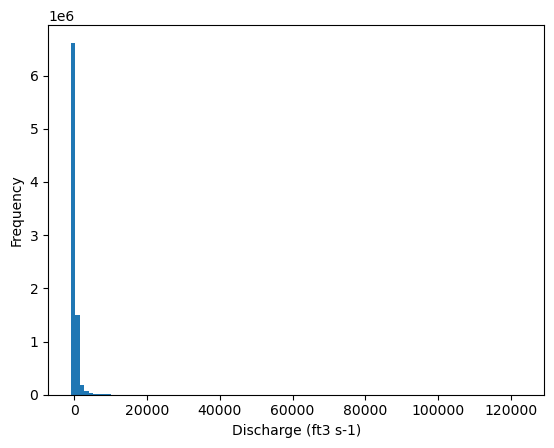